<a href="https://colab.research.google.com/github/ArielFerreiro/ar-stamp-checker/blob/main/attempt.01/04_VGG19_NoAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the imaged croped and without augmentation. We create a model using CNN VGG19 architecture pre-trained with imagenet and evaluate the accuracy results to get fake vs genuine stamps.


In [1]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Notebook Imports

In [3]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.applications.vgg19 import VGG19
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model,Sequential
from keras.layers.core import Dense, Flatten, Activation
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Dropout, MaxPooling2D, Input, Add
import numpy as np
import pickle
import os

#### Global Params

In [4]:
results_path = 'drive/My Drive/Colab Notebooks/stamps/results/'
models_path = 'drive/My Drive/Colab Notebooks/stamps/models/'
test_path = 'drive/My Drive/Colab Notebooks/stamps/test/'

#### Data Load

In [5]:
with open(results_path+"stamps_bb_224.pkl","rb") as f:
    (stamps_df, y) = pickle.load(f)

#### Model Creation

In [6]:
preproc= VGG19(include_top=False, input_shape=(224, 224, 3))

80142336/80134624 [==============================] - 1s 0us/step


In [7]:
# no training on first CNN layers
for layer in preproc.layers:
    layer.trainable = False

In [8]:
# Dictionary of Layers
outputs_dict = dict([(layer.name, layer.output) for layer in preproc.layers])

In [9]:
net = BatchNormalization(axis=3)(outputs_dict['block5_pool']) 
net=Flatten()(net)
net=Dense(units=256)(net)
net = Activation('relu')(net)
#net=Dropout(0.3)(net)
net=Dense(units=256)(net)
net = Activation('relu')(net)
#net=Dropout(0.3)(net)

# USES Softmax as it is a requirement for the TF Lite add-in used in the mobile app
net=Dense(units=2, activation = 'softmax', kernel_regularizer=keras.regularizers.L2(l2=0.02))(net)
 
model=Model(preproc.inputs,net)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [10]:
# Callbacks
checkpoint_file='checkpoint.pmi-cnn-vgg19.hdf5'
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [11]:
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', keras.metrics.AUC()])

In [12]:
epocs = 50
# Move the y-true to categorical
y_categorical = keras.utils.to_categorical(y)

In [13]:
stamps_df = stamps_df / 255

In [14]:
history = model.fit(x= stamps_df, y=y_categorical,
                    epochs=epocs, verbose=1, 
                    validation_split=0.2,
                    callbacks=[checkpointer, earlystop])

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.6236 - accuracy: 0.8662 - auc: 0.9280
Epoch 00001: val_accuracy improved from -inf to 0.01058, saving model to checkpoint.pmi-cnn-vgg19.hdf5
48/48 [==============================] - 11s 231ms/step - loss: 0.6236 - accuracy: 0.8662 - auc: 0.9280 - val_loss: 2.7651 - val_accuracy: 0.0106 - val_auc: 1.6097e-04
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.9470 - auc: 0.9792
Epoch 00002: val_accuracy improved from 0.01058 to 0.77249, saving model to checkpoint.pmi-cnn-vgg19.hdf5
48/48 [==============================] - 9s 190ms/step - loss: 0.2630 - accuracy: 0.9470 - auc: 0.9792 - val_loss: 0.6241 - val_accuracy: 0.7725 - val_auc: 0.8235
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.9781 - auc: 0.9951
Epoch 00003: val_accuracy improved from 0.77249 to 0.87302, saving model to checkpoint.pmi-cnn-vgg19.hdf5
48/48 [=======================

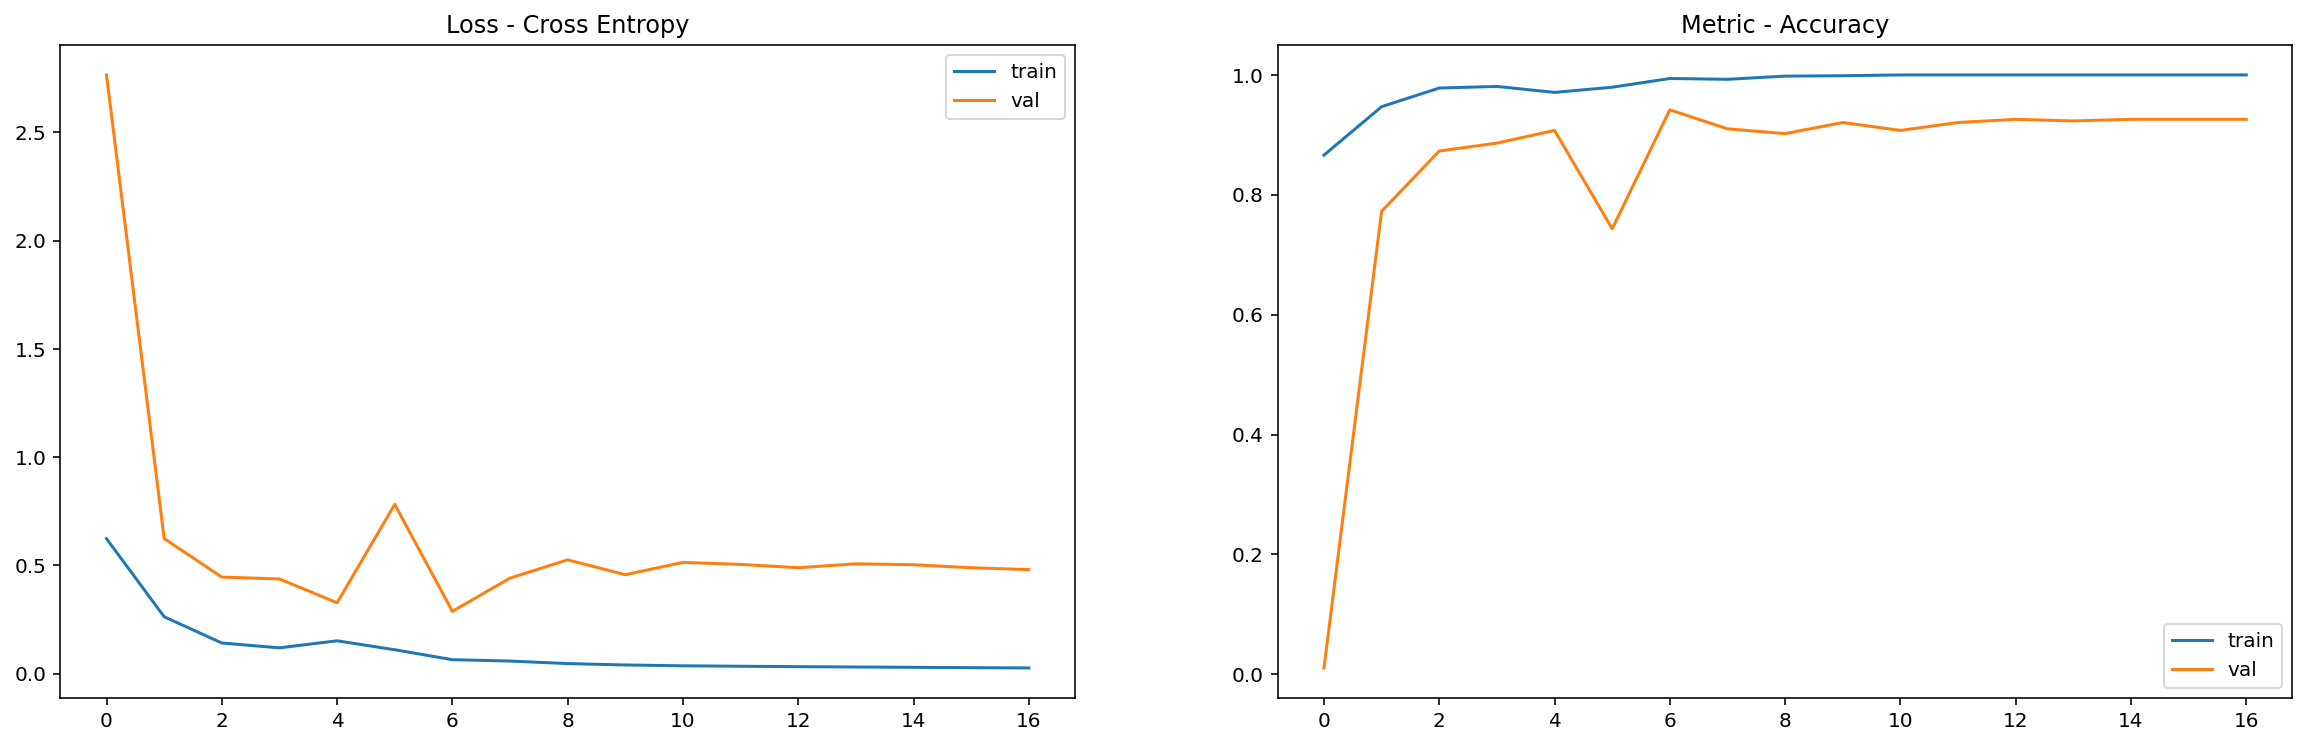

In [15]:
# Check results
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='val')
ax1.set_title('Loss - Cross Entropy')
ax1.legend()
ax2.plot(history.history['accuracy'], label='train')
ax2.plot(history.history['val_accuracy'], label='val')
ax2.set_title('Metric - Accuracy')
ax2.legend()
plt.show()

In [16]:
# Full Model training el modelo completo
for layer in model.layers:
    layer.trainable=True

In [17]:
# Retrain full model only 20 epochs
history = model.fit(x= stamps_df, y=y_categorical,
          epochs=20, 
          verbose=1, 
          validation_split=0.2,
          callbacks=[checkpointer, earlystop])

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 1.0000 - auc: 1.0000
Epoch 00001: val_accuracy did not improve from 0.94180
48/48 [==============================] - 9s 192ms/step - loss: 0.0254 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.4797 - val_accuracy: 0.9259 - val_auc: 0.9582
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 1.0000 - auc: 1.0000
Epoch 00002: val_accuracy did not improve from 0.94180
48/48 [==============================] - 9s 195ms/step - loss: 0.0241 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.4720 - val_accuracy: 0.9286 - val_auc: 0.9587
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 1.0000 - auc: 1.0000
Epoch 00003: val_accuracy did not improve from 0.94180
48/48 [==============================] - 10s 199ms/step - loss: 0.0229 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.4700 - val_accuracy: 0.9259 - val_auc: 0.9584
Epoch 4/20
48/48 [===

In [18]:
# Save model and weights without training initial layers
for layer in model.layers:
    layer.trainable=False

# take best weights from training
model_name = 'vgg19_noaug_softmax_2.h5'
model.load_weights(checkpoint_file)

In [19]:
model.save(models_path + model_name)
model.save_weights(models_path + 'weights_' + model_name)

#### Test

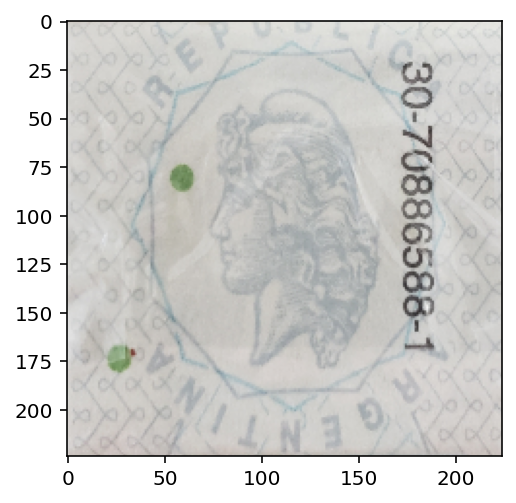

In [22]:
import cv2

imagen_1 = cv2.imread(test_path + 'cft_soft/20201016_113950.jpg' )
map = cv2.cvtColor(imagen_1, cv2.COLOR_BGR2RGB)
map = cv2.resize(map, dsize=(224,224))
plt.imshow(map)

In [23]:
map = map / 255
map = np.expand_dims(map, axis=0)
pred_1 = model.predict(map)
pred_1

# 0-1: fake
# 1-0: genuine

array([[7.4082874e-07, 9.9999928e-01]], dtype=float32)